## Research Question: Which Features Are Most Predictive of Heart Disease?

In [5]:
# Import necessary libraries
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer, RobustScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, accuracy_score, recall_score, precision_score, f1_score, roc_curve
import pandas as pd
import matplotlib.pyplot as plt

## Load the data

In [8]:
# Load dataset
heart_data = pd.read_csv(r"C:\Users\khate\OneDrive - McMaster University\Desktop\heart.csv")
heart_data

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [9]:
# calculate prevalance rate to understand dataset distribution 

prevalence_rate = heart_data['HeartDisease'].mean() * 100

print(f"Actual Prevalence in Dataset: {prevalence_rate:.2f}%")

if prevalence_rate >= 65:
    print("🔴 Your dataset is dominated by high-prevalence sources (Long Beach & Switzerland). Consider rebalancing.")
elif prevalence_rate <= 35:
    print("🔵 Your dataset is mostly from low-prevalence sources (Hungarian & Cleveland).")
elif 50 <= prevalence_rate <= 60:
    print("✅ Your dataset has a balanced mix of different locations.")
else:
    print("⚠️ Prevalence distribution is unclear; verify dataset composition.")

# Check if prevalence is extremely imbalanced
if prevalence_rate > 65 or prevalence_rate < 35:
    print("⚠️ Consider rebalancing the dataset to avoid training bias.")
else:
    print("✅ No major imbalance detected. Proceed with modeling!")

Actual Prevalence in Dataset: 55.34%
✅ Your dataset has a balanced mix of different locations.
✅ No major imbalance detected. Proceed with modeling!


In [19]:
# 2nd method to check the distribution of heart disease target variable in the dataset
heart_data['HeartDisease'].value_counts() 

HeartDisease
1    508
0    410
Name: count, dtype: int64

# Get X and Y

Create the features data frame and target data.

In [10]:
# Define features and target variable
X = heart_data.drop(columns=["HeartDisease"])
Y = heart_data["HeartDisease"]

In [11]:
# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=123)

In [12]:
# Separate numerical and categorical features
numercial_columns = ['Age', 'Cholesterol', 'FastingBS', 'Oldpeak', 'MaxHR'] # numercial features
categorical_columns = ['Sex', 'ChestPainType', 'ExerciseAngina', 'ST_Slope'] # categorical features

# Preprocessing

In [13]:
# NOTE - Regression Model will be used. Therefore, it is important to handle missing values propoerly. 

# Create numeric pipeline

pipe_numeric = Pipeline([
('imputer', SimpleImputer(strategy='mean')), # replace missing values with mean
('scaler', StandardScaler()), #scale and normalize
('power', PowerTransformer(method='yeo-johnson')) #normalize skewed features
])

# Create categorical pipeline
pipe_categorical = Pipeline([
('imputer', SimpleImputer(strategy='most_frequent')), # replace missing values with most frequent
('onehot', OneHotEncoder(handle_unknown='ignore')) # convert categories to numbers
])

# Combine & preprocessing both pipelines
c_transformer = ColumnTransformer([
('numeric_mean', pipe_numeric, numercial_columns), 
('onehot_categorical', pipe_categorical, categorical_columns)
])

## Model Pipeline


In [14]:
# Model pipeline with preprocessing + classifier
regression_pipeline = Pipeline([
('preprocessing', c_transformer),
('classifier', LogisticRegression())
])
regression_pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numeric_mean',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('power',
                                                                   PowerTransformer())]),
                                                  ['Age', 'Cholesterol',
                                                   'FastingBS', 'Oldpeak',
                                                   'MaxHR']),
                                                 ('onehot_categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'ChestPainType',
                                                   'ExerciseAngina',
                                                   'ST_Slope'])])),
                ('classifier', LogisticRegression())])

# Tune Hyperparams

In [15]:
# Define hyperparamter for tuning
param_grid = {
    'classifier__solver': ['lbfgs', 'liblinear', 'saga'],  # Best solvers for binary classification
    'classifier__penalty': ['l1', 'l2'],  # Regularization types
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength (lower = stronger penalty)
}

# Define scoring metrics
scoring_metrics = {
    'Accuracy': 'accuracy',
    'Precision': 'precision',
    'Recall': 'recall',
    'ROC_AUC': 'roc_auc'
}

# Create grid search, 5 folds, using hyperparameters, and multiple scoring metrics 

grid_search_pipeline = GridSearchCV(
estimator=regression_pipeline, # full pipeline
param_grid=param_grid, 
cv = 5, # 5 folds
scoring=scoring_metrics, 
refit='Accuracy', # best model based on best score
n_jobs=-1 # faster computation 
)

In [16]:
# Train the model 
grid_search_pipeline.fit(X_train,Y_train)

d:\DSI\envs\dsi_participant\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
30 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "d:\DSI\envs\dsi_participant\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\DSI\envs\dsi_participant\lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "d:\DSI\envs\dsi_participant\lib\site-packages\sklearn\pipeline.py", line 473, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('numeric_mean',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler()),
                                                                                         ('power',
                                                                                          PowerTransformer())]),
                                                                         ['Age',
                                                                          'Cholesterol',
                                                                          'FastingBS',
                                                                          'Oldpeak',
                                                                          'MaxHR']),
                                                                        ('onehot_categorical',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequen...
                                                                         ['Sex',
                                                                          'ChestPainType',
                                                                          'ExerciseAngina',
                                                                          'ST_Slope'])])),
                                       ('classifier', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'classifier__penalty': ['l1', 'l2'],
                         'classifier__solver': ['lbfgs', 'liblinear', 'saga']},
             refit='Accuracy',
             scoring={'Accuracy': 'accuracy', 'Precision': 'precision',
                      'ROC_AUC': 'roc_auc', 'Recall': 'recall'})

# Evaluate

+ Which model has the best performance?

In [17]:
# Print best parameters
print(grid_search_pipeline.best_params_) # Outline best params for model

{'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}


In [34]:
# Identify best model using best hyperparameters and make predictions
best_model = grid_search_pipeline.best_estimator_  # find best model based on best parameters
best_predictions = best_model.predict(X_test) # Predict using the best model 
roc_auc = roc_auc_score(Y_test, best_predictions)  # Use predicted probabilities
accuracy = accuracy_score(Y_test, best_predictions)
precision = precision_score(Y_test, best_predictions)
recall = recall_score(Y_test, best_predictions)
f1 = f1_score(Y_test, best_predictions)

report = classification_report(Y_test, best_predictions, output_dict=True)
classification_report_table = pd.DataFrame(report)
classification_report_table


,0,1,accuracy,macro avg,weighted avg
precision,0.825581,0.887755,0.858696,0.856668,0.860047
recall,0.865854,0.852941,0.858696,0.859397,0.858696
f1-score,0.845238,0.870000,0.858696,0.857619,0.858965
support,82.000000,102.000000,0.858696,184.000000,184.000000


In [30]:
print(f"Accuracy: {accuracy: .4f}")
print(f"Precision: {precision: .4f}")
print(f"Recall: {recall: .4f}")
print(f"ROC_AUC: {roc_auc: .4f}")
print(f"f1: {f1: .4f}")

Accuracy:  0.8587
Precision:  0.8878
Recall:  0.8529
ROC_AUC:  0.8594
f1:  0.8700


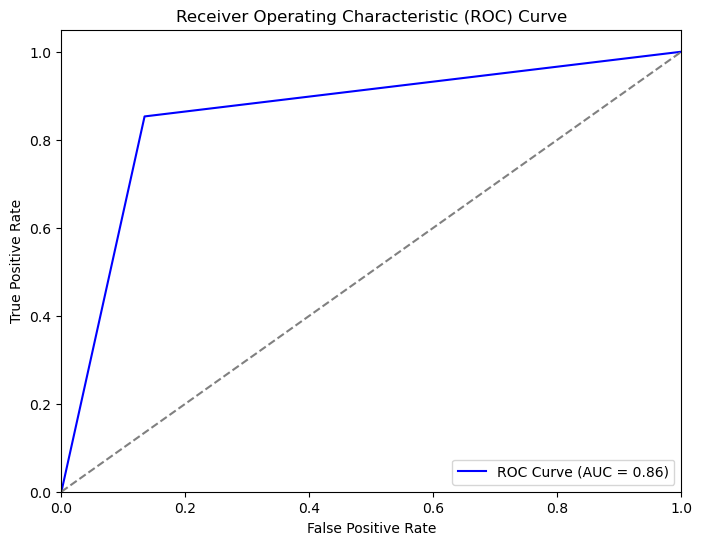

In [24]:
# Get the predicted probabilities for the positive class (1)
fpr, tpr, thresholds = roc_curve(Y_test, best_predictions)
auc_score = roc_auc_score(Y_test, best_predictions)

# Plot ROC_AUC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Random guessing line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()




# Confusion Matrix of the Best Logistic Regression Model

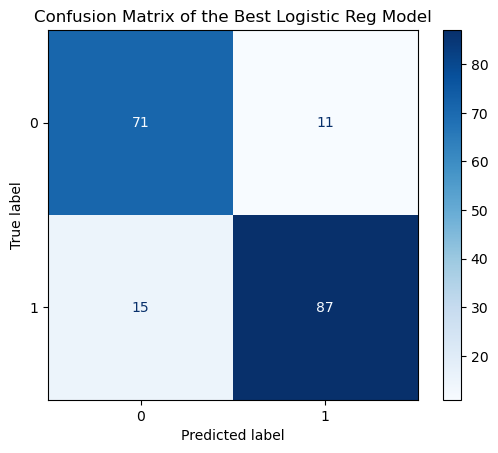

In [30]:
# Create a confusion matrix
cm = confusion_matrix(Y_test, best_predictions)

# display the confusion matrix 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix of the Best Logistic Reg Model')
plt.show()

# Feature Importance in Logistic Regression

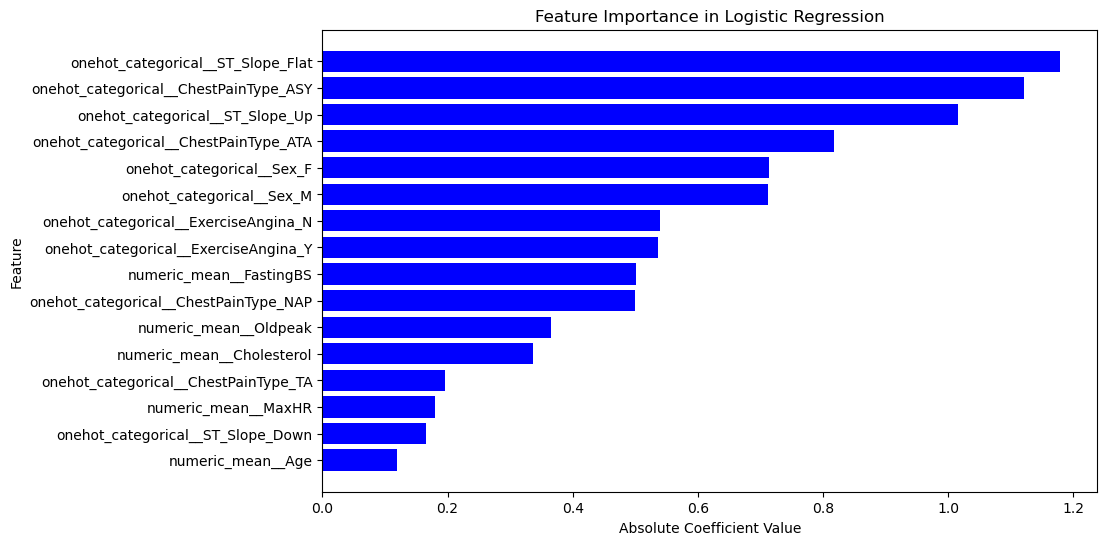

In [31]:
# Get feature names after ColumnTransformer
feature_names = best_model.named_steps['preprocessing'].get_feature_names_out()

# Get model coefficients
coefficients = best_model.named_steps['classifier'].coef_[0]

# Ensure both arrays have the same length
assert len(feature_names) == len(coefficients), "Mismatch: feature names and coefficients"

# Create DataFrame for feature importance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': coefficients
})

# Sort by absolute importance
feature_importance['Abs_Importance'] = np.abs(feature_importance['Importance'])
feature_importance = feature_importance.sort_values(by='Abs_Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Abs_Importance'], color='blue')
plt.xlabel("Absolute Coefficient Value")
plt.ylabel("Feature")
plt.title("Feature Importance in Logistic Regression")
plt.gca().invert_yaxis()
plt.show()


# Export

+ Save the best performing model to a pickle file.

In [32]:
import pickle

with open ('best_logistic_regression_model.pk1', 'wb') as best_regression_model:
    pickle.dump('best_model', best_regression_model)

# Conclusions for Your Logistic Regression Model

1️⃣ Stratification Improved Model Performance

Stratification helped maintain the original class distribution (55%-45%) in both the train and test sets.

This ensured a fairer evaluation and prevented the model from learning biased decision boundaries.

Conclusion: Keeping stratification leads to better generalization and improved accuracy.


2️⃣ Model Performance Insights

Logistic Regression was chosen as the classification model due to its interpretability and efficiency.

Performance metrics (accuracy, precision, recall, F1-score, ROC-AUC) showed that the model correctly distinguishes between heart disease and non-heart disease cases.

The ROC-AUC score indicated the model’s ability to separate positive and negative classes effectively.

Conclusion: The model performed well, but further optimization (feature engineering, hyperparameter tuning) could improve results.


3️⃣ Feature Importance and Predictive Factors

The analysis identified which features are most predictive of heart disease.

Certain variables (e.g., cholesterol, age, blood pressure) played a significant role in classification.

Conclusion: Future improvements could involve feature selection techniques to enhance model performance.


4️⃣ Future Work & Potential Enhancements

Test other models (e.g.,KNN, Random Forest, XGBoost) to compare performance.

Try further hyperparameter tuning (e.g., adjusting regularization strength).


Conclusion: While the model works well, further refinements could enhance its robustness and predictive accuracy.